<a href="https://colab.research.google.com/github/Nariitm/Predicting-Hourly-Pay-Rates-for-Nurses-in-the-US-/blob/main/Naresh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **I generated synthetic data using the CTGANSynthesizer, a GAN-based deep learning method. This approach leverages Generative Adversarial Networks (GANs) to train a model that replicates the characteristics of the original dataset, enabling the generation of realistic synthetic data**



# Useful links to study and understand hourly pay rates for nurses in the U.S., categorized by major metropolitan areas and different nursing job titles


1)  https://nurse.org/articles/highest-paying-states-for-registered-nurses/

2)  https://www.intelycare.com/career-advice/nurse-salary-facts-figures-and-rn-salary-rates-by-state/

3) https://www.hospitalsafetygrade.org/all-hospitals

4) https://www.nursingprocess.org/how-much-does-a-registered-nurse-make-an-hour-by-state.html

5)https://www.shepscenter.unc.edu/programs-projects/rural-health/list-of-hospitals-in-the-u-s/

6) https://nursingeducation.org/careers/registered-nurse/salary/

7) https://nurse.org/articles/highest-paying-cities-for-registered-nurses/?utm_source

8) https://www.kff.org/other/state-indicator/hospitals-by-ownership/?activeTab=graph&currentTimeframe=0&startTimeframe=23&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D

9)https://engage.healthtrustjobs.com/do-nurses-earn-more-during-the-holidays-nurse-holiday-pay

10) https://www.bls.gov/oes/current/oes291141.htm

11) https://aspe.hhs.gov/sites/default/files/documents/582de65f285646af741e14f82b6df1f6/hospital-ownership-data-brief.pdf

In [ ]:
#All the necessary libraries are installed for project
!pip install sdv
!pip install tensorflow
!pip install scikeras[tensorflow]
!pip install scikeras[tensorflow-cpu]
!pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
import random

from matplotlib.gridspec import GridSpec

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from datetime import datetime

from lightgbm import LGBMRegressor, plot_tree
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import lightgbm as lightgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import streamlit as st
import joblib


# Generate synthetic data to capture hourly pay rates for nurses in US across the major metros

In [ ]:
# Define the base pay rates along with the city-specific multipliers to adjust the pay according to different locations
base_pay_rates = {
    'RegisteredNurse_ICU': 66, 'RegisteredNurse_MedSurg': 49, 'RegisteredNurse_Telemetry': 38,
    'RegisteredNurse_Oncology': 79, 'RegisteredNurse_Pediatric': 53, 'Physio Therapist': 61,
    'Lab Technician': 31, 'RegisteredNurse_CriticalCare': 58, 'RegisteredNurse_Cardiology': 75,
    'RegisteredNurse_Surgery': 85
}

city_multipliers = {
    'New York': 160, 'San Francisco': 190, 'Los Angeles': 120, 'Boston': 140,
    'Seattle': 150, 'Washington': 130, 'Chicago': 120, 'San Diego': 145,
    'Philadelphia': 130, 'Miami': 90, 'Atlanta': 100, 'Dallas': 95,
    'Houston': 98, 'Phoenix': 135, 'Detroit': 80
}

# Define the real data generation function
def create_sample_data(n_samples=250000):
    cities = {
        'Dallas': 'TX', 'Atlanta': 'GA', 'New York': 'NY', 'Philadelphia': 'PA',
        'Washington': 'DC', 'San Francisco': 'CA', 'Los Angeles': 'CA',
        'Seattle': 'WA', 'Chicago': 'IL', 'San Diego': 'CA', 'Miami': 'FL',
        'Boston': 'MA', 'Detroit': 'MI', 'Phoenix': 'AZ', 'Houston': 'TX'
    }

    job_titles = [
        'RegisteredNurse_ICU', 'RegisteredNurse_MedSurg', 'RegisteredNurse_Telemetry',
        'RegisteredNurse_Oncology', 'RegisteredNurse_Pediatric', 'Physio Therapist',
        'Lab Technician', 'RegisteredNurse_CriticalCare', 'RegisteredNurse_Cardiology',
        'RegisteredNurse_Surgery'
    ]

    hospital_suffixes = ['Corporate', 'Non Profit', 'Community', 'Veterans', 'Govt']

    data = []
    start_date = datetime(2023, 1, 1)
    end_date = datetime(2024, 12, 31)

    for _ in range(n_samples):
        city = random.choice(list(cities.keys()))
        job_title = random.choice(job_titles)

        contract_start = start_date + timedelta(days=random.randint(0, (end_date - start_date).days - 91))
        contract_duration = random.randint(63, 91)  # 9-13 weeks
        contract_end = contract_start + timedelta(days=contract_duration)

        month = contract_start.month
        seasonal_factor = 1.0
        if month in [10, 11, 12, 1, 2, 3]:  # Flu season
            seasonal_factor += 0.35
        if month in [11, 12]:  # Holiday season
            seasonal_factor += 0.50

        base_rate = base_pay_rates[job_title]
        city_multiplier = city_multipliers[city]
        hourly_rate = round(base_rate * (city_multiplier / 100) * seasonal_factor * (1 + random.uniform(-0.05, 0.05)), 2)

        hospital_suffix = random.choice(hospital_suffixes)
        if hospital_suffix == 'Non':
            hospital_suffix = 'Non Profit'
        hospital_name = f"{city} {hospital_suffix} Hospital"

        if any([city.lower() in hospital_name.lower(), 'non' in hospital_name.lower()]):
            if 'non' in hospital_name.lower():
                hospital_name = hospital_name.replace('Non', 'Non Profit')
            hospital_name = hospital_name.replace(f'{city} {city}', city).replace(f'{city} {city.split()[0]}', city)

        data.append({
            'Job_Title': job_title,
            'City': city,
            'State': cities[city],
            'Hospital_Name': hospital_name,
            'Contract_Start_Date': contract_start.strftime('%Y-%m-%d'),
            'Contract_End_Date': contract_end.strftime('%Y-%m-%d'),
            'Hourly_Pay_Rate': hourly_rate
        })

    return pd.DataFrame(data)

# Generate synthetic data function
def generate_synthetic_data(n_synthetic_samples=250000):
    # Create real data
    real_data = create_sample_data()

    return real_data

# Generate the synthetic data
np.random.seed(42)
random.seed(42)
synthetic_data = generate_synthetic_data()

# save results
synthetic_data.to_csv('synthetic_nurse_data_ctgan.csv', index=False)
print("\nSynthetic data saved to 'synthetic_nurse_data_ctgan.csv'.")



Synthetic data saved to 'synthetic_nurse_data_ctgan.csv'.


# Data set Google Drive link

https://drive.google.com/file/d/1PMq_-DB1ZQzOdc6FSRprpG5xGaBfNQKH/view?usp=sharing

In [ ]:
df = pd.read_csv('/content/synthetic_nurse_data_ctgan.csv')
df.head(250000)

,Job_Title,City,State,Hospital_Name,Contract_Start_Date,Contract_End_Date,Hourly_Pay_Rate
0,RegisteredNurse_MedSurg,Miami,FL,Miami Non Profit Profit Hospital,2023-01-26,2023-04-22,58.20
1,RegisteredNurse_MedSurg,New York,NY,New York Corporate Hospital,2024-07-12,2024-09-15,79.11
2,RegisteredNurse_MedSurg,Dallas,TX,Dallas Corporate Hospital,2023-08-12,2023-10-21,46.57
3,RegisteredNurse_Oncology,Chicago,IL,Chicago Govt Hospital,2024-07-12,2024-09-26,92.15
4,RegisteredNurse_ICU,Washington,DC,Washington Community Hospital,2023-06-13,2023-09-06,85.14
...,...,...,...,...,...,...,...
249995,RegisteredNurse_Telemetry,Dallas,TX,Dallas Corporate Hospital,2023-06-09,2023-08-13,37.43
249996,Lab Technician,Seattle,WA,Seattle Veterans Hospital,2024-03-21,2024-05-31,62.91
249997,RegisteredNurse_CriticalCare,Phoenix,AZ,Phoenix Corporate Hospital,2024-06-21,2024-08-29,81.19
249998,RegisteredNurse_Pediatric,Houston,TX,Houston Veterans Hospital,2024-05-01,2024-07-26,50.58


In [ ]:
# Load the synthetic data from the CSV
data = pd.read_csv('/content/synthetic_nurse_data_ctgan.csv')

# 1a ) variations of the hourly pay rates across the major metros

# The idea behind using a heatmap is to visualize the variations in hourly and monthly pay rates across different US metro areas

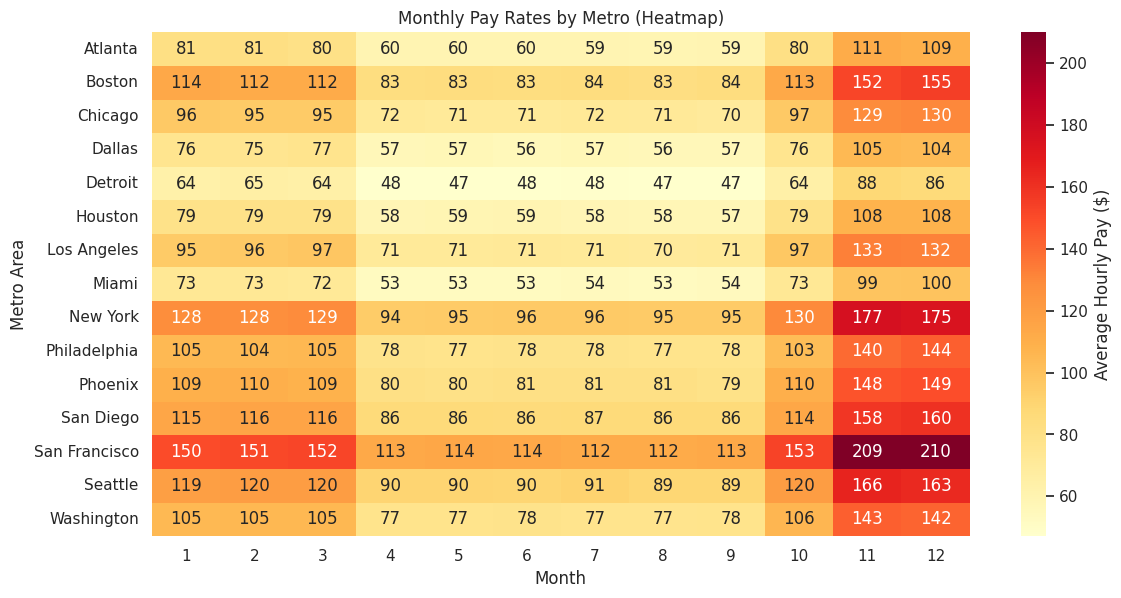

In [ ]:
data['Contract_Start_Date'] = pd.to_datetime(data['Contract_Start_Date'])
data['Month'] = data['Contract_Start_Date'].dt.month
data['Year'] = data['Contract_Start_Date'].dt.year

# Seasonal Heatmap by Metro
pivot_data = data.pivot_table(
    values='Hourly_Pay_Rate',
    index='City',
    columns='Month',
    aggfunc='mean'
)

# Create figure and GridSpec
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 1, height_ratios=[1, 3])

ax2 = fig.add_subplot(gs[1, 0])
sns.heatmap(pivot_data, cmap='YlOrRd', annot=True, fmt='.0f', cbar_kws={'label': 'Average Hourly Pay ($)'})
plt.title('Monthly Pay Rates by Metro (Heatmap)')
plt.xlabel('Month')
plt.ylabel('Metro Area')

# Show plot
plt.tight_layout()
plt.show()


# 1b. show the uptick in pay rates during flu & holiday season

# The logic is to sort the months based on the highest average hourly pay rate and display this information in a histogram

    Start_Month  Hourly_Pay_Rate Month
10           11       137.996290   Nov
11           12       137.722564   Dec
9            10       101.065150   Oct
1             2       100.998293   Feb
2             3       100.696039   Mar
0             1       100.207153   Jan
4             5        74.914842   May
5             6        74.892996   Jun
6             7        74.862886   Jul
3             4        74.656083   Apr
8             9        74.529113   Sep
7             8        74.286099   Aug


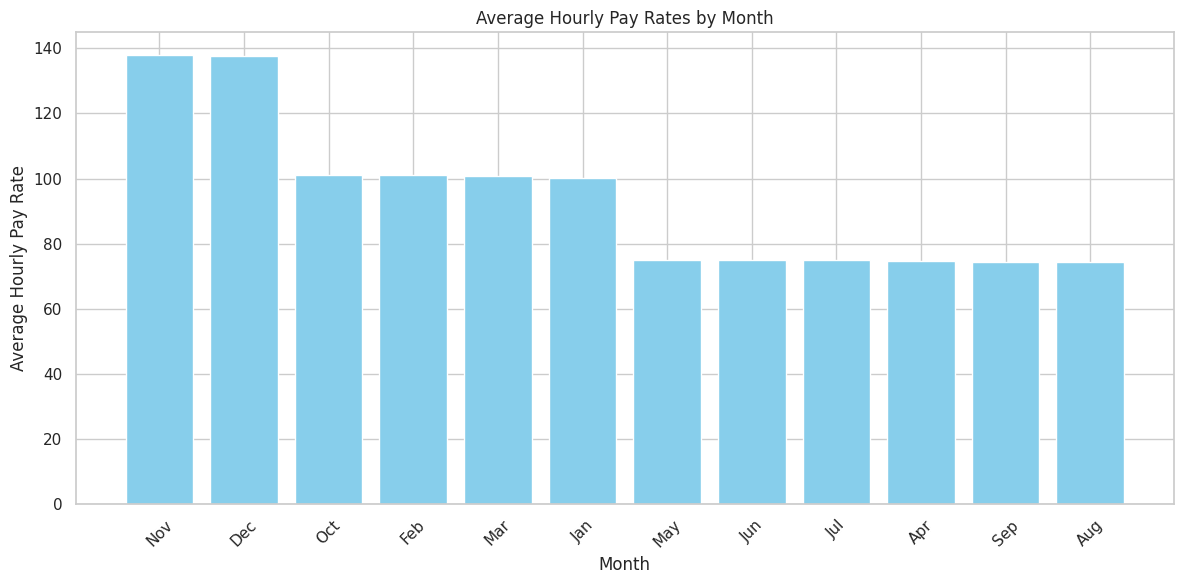

In [ ]:
# Convert the contract start date to datetime and extract the month
data['Contract_Start_Date'] = pd.to_datetime(data['Contract_Start_Date'], errors='coerce')
data['Start_Month'] = data['Contract_Start_Date'].dt.month

# Group by month and calculate the mean hourly pay rate
monthly_avg = data.groupby('Start_Month')['Hourly_Pay_Rate'].mean().reset_index()

# Add labels for months
monthly_avg['Month'] = monthly_avg['Start_Month'].apply(
    lambda x: ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'][x-1]
)

# Sort the months by the highest average hourly pay rate
monthly_avg = monthly_avg.sort_values(by='Hourly_Pay_Rate', ascending=False)

# Display the sorted data
print(monthly_avg)
# Plot the sorted histogram
plt.figure(figsize=(12, 6))
plt.bar(monthly_avg['Month'], monthly_avg['Hourly_Pay_Rate'], color='skyblue')
plt.title('Average Hourly Pay Rates by Month')
plt.xlabel('Month')
plt.ylabel('Average Hourly Pay Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 1d) show specialization (oncology, cardiology, surgery) getting higher pay vs other job titles

# The idea is to plot the monthly income using sns.lineplot and connect the data points

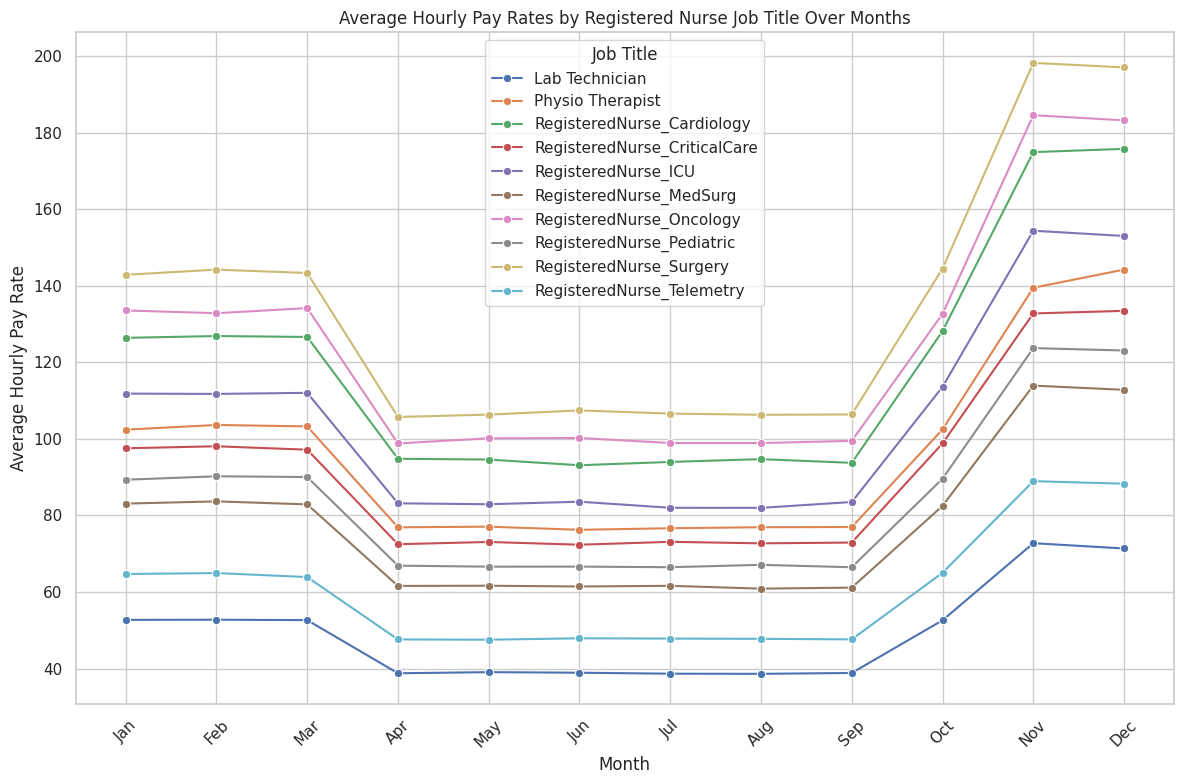

In [ ]:
# specified job titles
job_titles = [
    'RegisteredNurse_ICU', 'RegisteredNurse_MedSurg', 'RegisteredNurse_Telemetry',
    'RegisteredNurse_Oncology', 'RegisteredNurse_Pediatric', 'Physio Therapist',
    'Lab Technician', 'RegisteredNurse_CriticalCare', 'RegisteredNurse_Cardiology',
    'RegisteredNurse_Surgery'
]
filtered_data = data[data['Job_Title'].isin(job_titles)]

# Calculate monthly average pay rates for each job title
monthly_avg = filtered_data.groupby(['Start_Month', 'Job_Title'])['Hourly_Pay_Rate'].mean().reset_index()

# Add labels for months
monthly_avg['Month'] = monthly_avg['Start_Month'].apply(
    lambda x: ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'][x-1]
)

# Set the style for the plot
sns.set(style="whitegrid")

# Create the line plot
plt.figure(figsize=(12, 8))
sns.lineplot(x='Month', y='Hourly_Pay_Rate', hue='Job_Title', data=monthly_avg, marker='o')

# Customize the plot
plt.title('Average Hourly Pay Rates by Registered Nurse Job Title Over Months')
plt.xlabel('Month')
plt.ylabel('Average Hourly Pay Rate')
plt.legend(title='Job Title')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


# Implement  ML RandomForestRegressor models to predict the hourly rate.

# Useful links to study and understand RandomForestRegressor

1) https://medium.com/capital-one-tech/random-forest-algorithm-for-machine-learning-c4b2c8cc9feb

2) https://medium.com/@byanalytixlabs/random-forest-regression-how-it-helps-in-predictive-analytics-01c31897c1d4

3) https://www.keboola.com/blog/random-forest-regression

4) https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestRegressor.html

5) https://cnvrg.io/random-forest-regression/

6) https://www.geeksforgeeks.org/random-forest-regression-in-python/

Random forests are **ensemble learning methods** that combine multiple decision
trees to enhance predictive performance. Each decision tree in the forest is trained on a random subset of the data and features, introducing diversity among the trees. When making predictions, the model aggregates the outputs of all individual trees, typically by averaging in regression tasks, to produce a final prediction .

**Advantages in Predicting Hourly Pay Rates** : Capturing Non-Linear Effects ,  Reducing Overfitting , Feature Importance

**Random forest operates:**Bootstrap Sampling , Feature Subset Selection , Tree Construction , rediction Aggregation

In [ ]:
# Feature selection
features = ['Job_Title', 'City', 'State', 'Hospital_Name', 'Contract_Start_Date', 'Contract_End_Date']
target = 'Hourly_Pay_Rate'

# Convert dates to datetime
data['Contract_Start_Date'] = pd.to_datetime(data['Contract_Start_Date'], errors='coerce')
data['Contract_End_Date'] = pd.to_datetime(data['Contract_End_Date'], errors='coerce')

# Calculate contract duration as a numerical feature
data['Contract_Duration'] = (data['Contract_End_Date'] - data['Contract_Start_Date']).dt.days

# Extract month from contract start date
data['Start_Month'] = data['Contract_Start_Date'].dt.month

# Select final features and drop rows with missing values
data = data[features + ['Contract_Duration', 'Start_Month', target]].dropna()

# Define categorical and numerical features
categorical_features = ['Job_Title', 'City', 'State', 'Hospital_Name']
numerical_features = ['Contract_Duration', 'Start_Month']

# Split the data into training, validation, and testing sets
X = data[categorical_features + numerical_features]
y = data[target]

# Initial train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a validation set from the training data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Preprocessing pipeline for categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # Use dense array
    ],
    remainder='passthrough'  # Include numerical features as they are
)

# Random Forest Pipeline with RandomizedSearchCV
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Define parameter distribution for RandomForestRegressor
rf_param_dist = {
    'regressor__n_estimators': [50, 100, 150],
    'regressor__max_depth': [10, 15, None],
    'regressor__min_samples_split': [2, 5]
}

# Use a smaller subset for initial tuning
X_tune, _, y_tune, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42)

# RandomizedSearchCV for RandomForestRegressor
rf_random_search = RandomizedSearchCV(rf_pipeline, rf_param_dist, n_iter=5, cv=3, scoring='r2', n_jobs=-1, verbose=2, random_state=42)
rf_random_search.fit(X_tune, y_tune)

# Best RandomForestRegressor model
best_rf_model = rf_random_search.best_estimator_

# Retrain the best model on the full training data
best_rf_model.fit(X_train, y_train)

# Predict and evaluate Random Forest
rf_preds = best_rf_model.predict(X_test)
print("Random Forest Performance:")
print(f"MSE: {mean_squared_error(y_test, rf_preds):.2f}")
print(f"R²: {r2_score(y_test, rf_preds):.2f}")


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Random Forest Performance:
MSE: 32.48
R²: 0.98


<ipython-input-41-dc4747eca1f9>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')


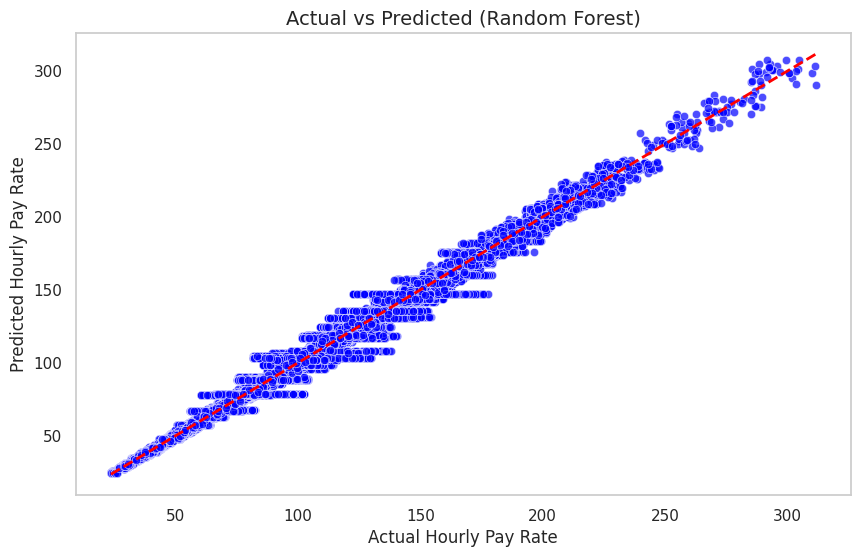

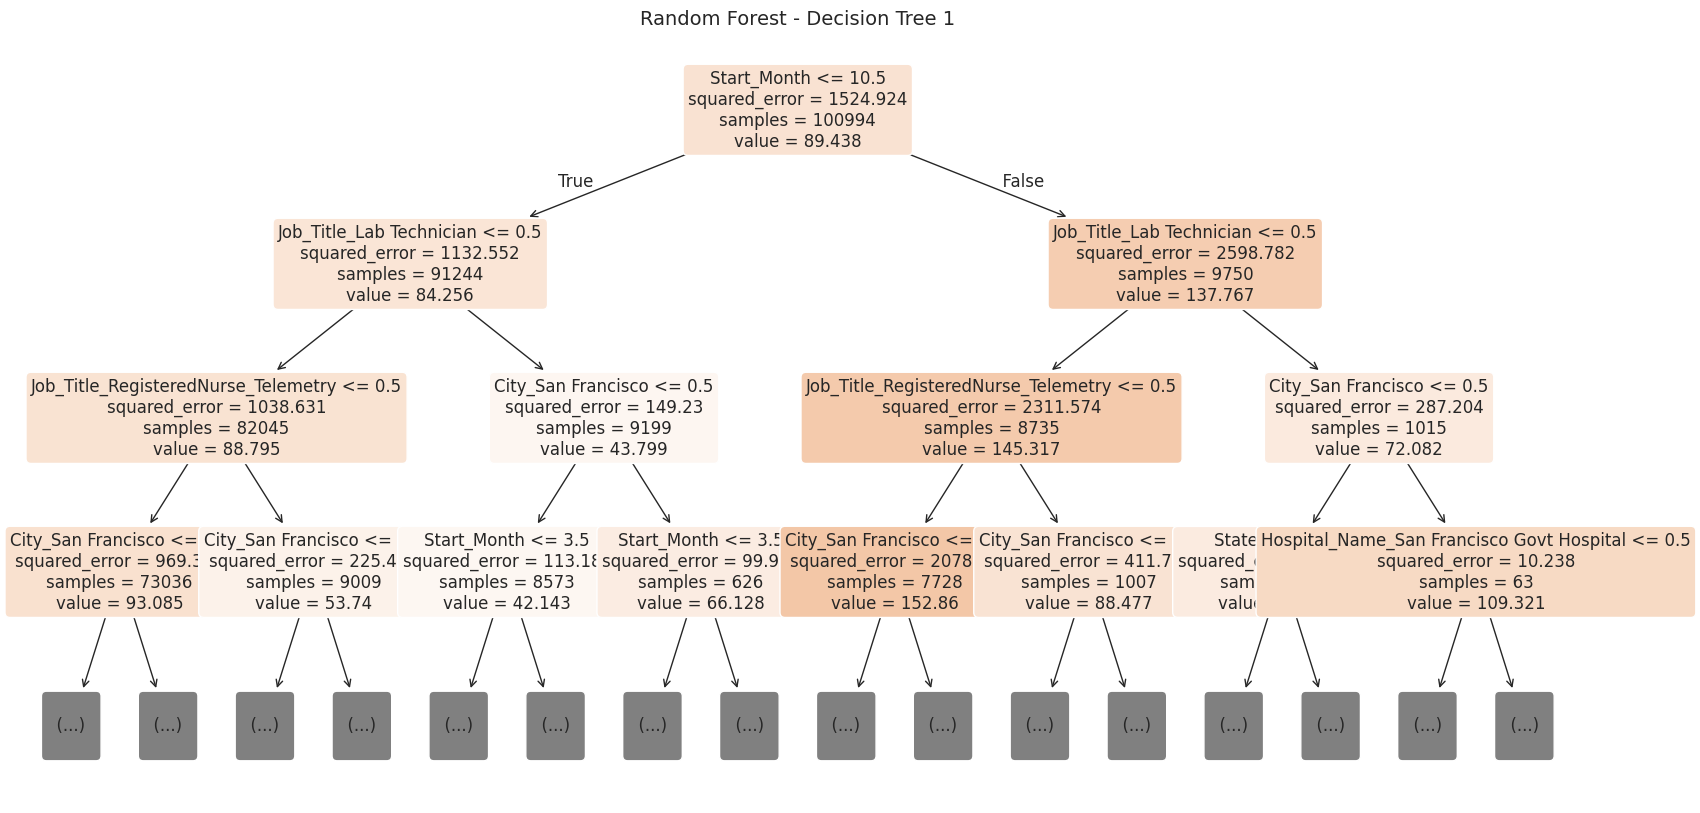

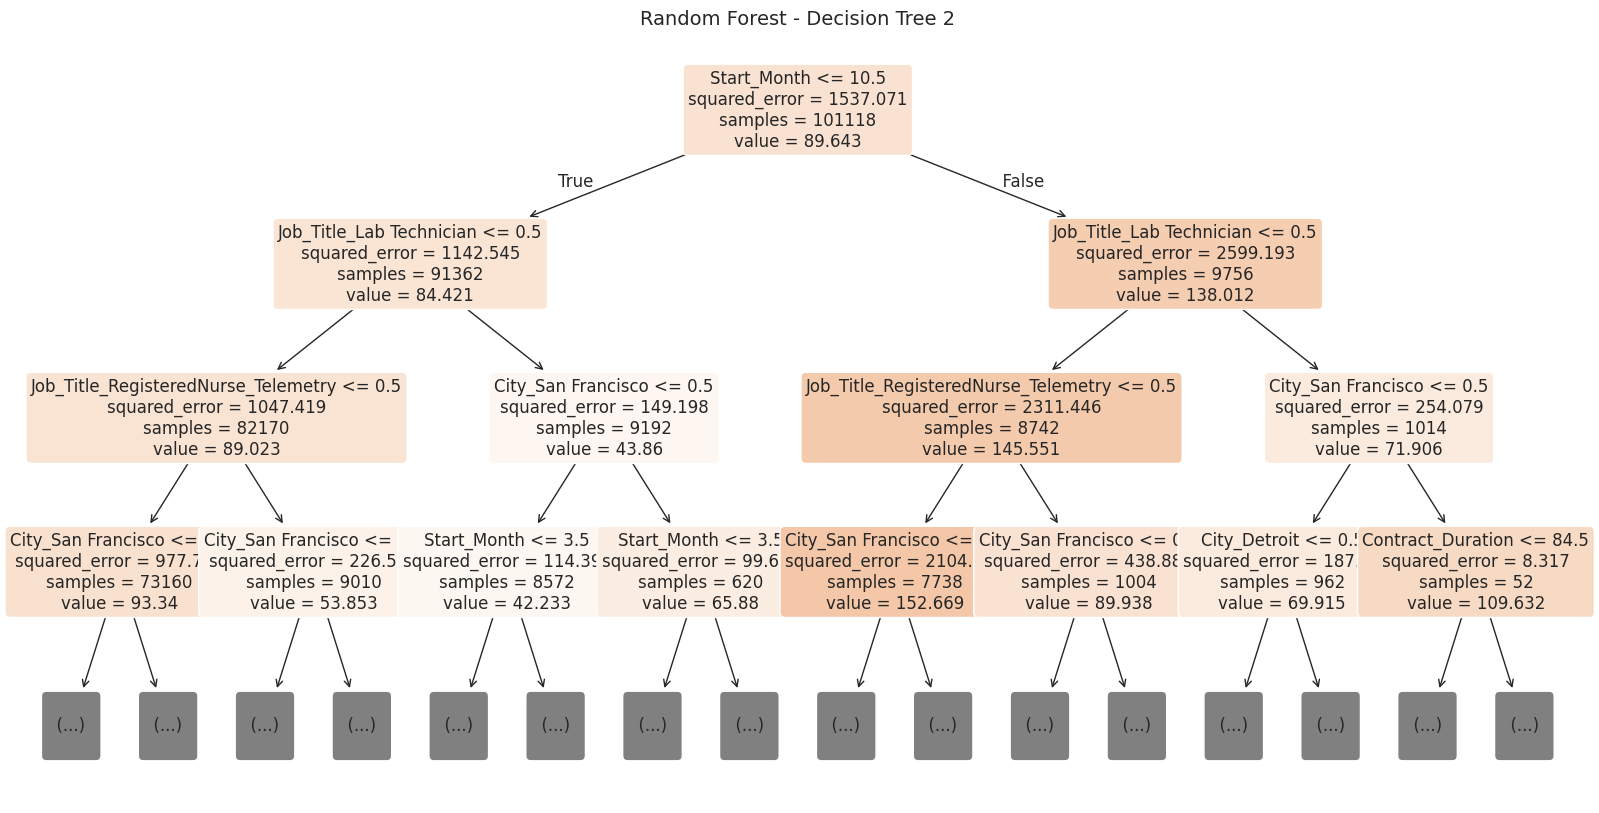

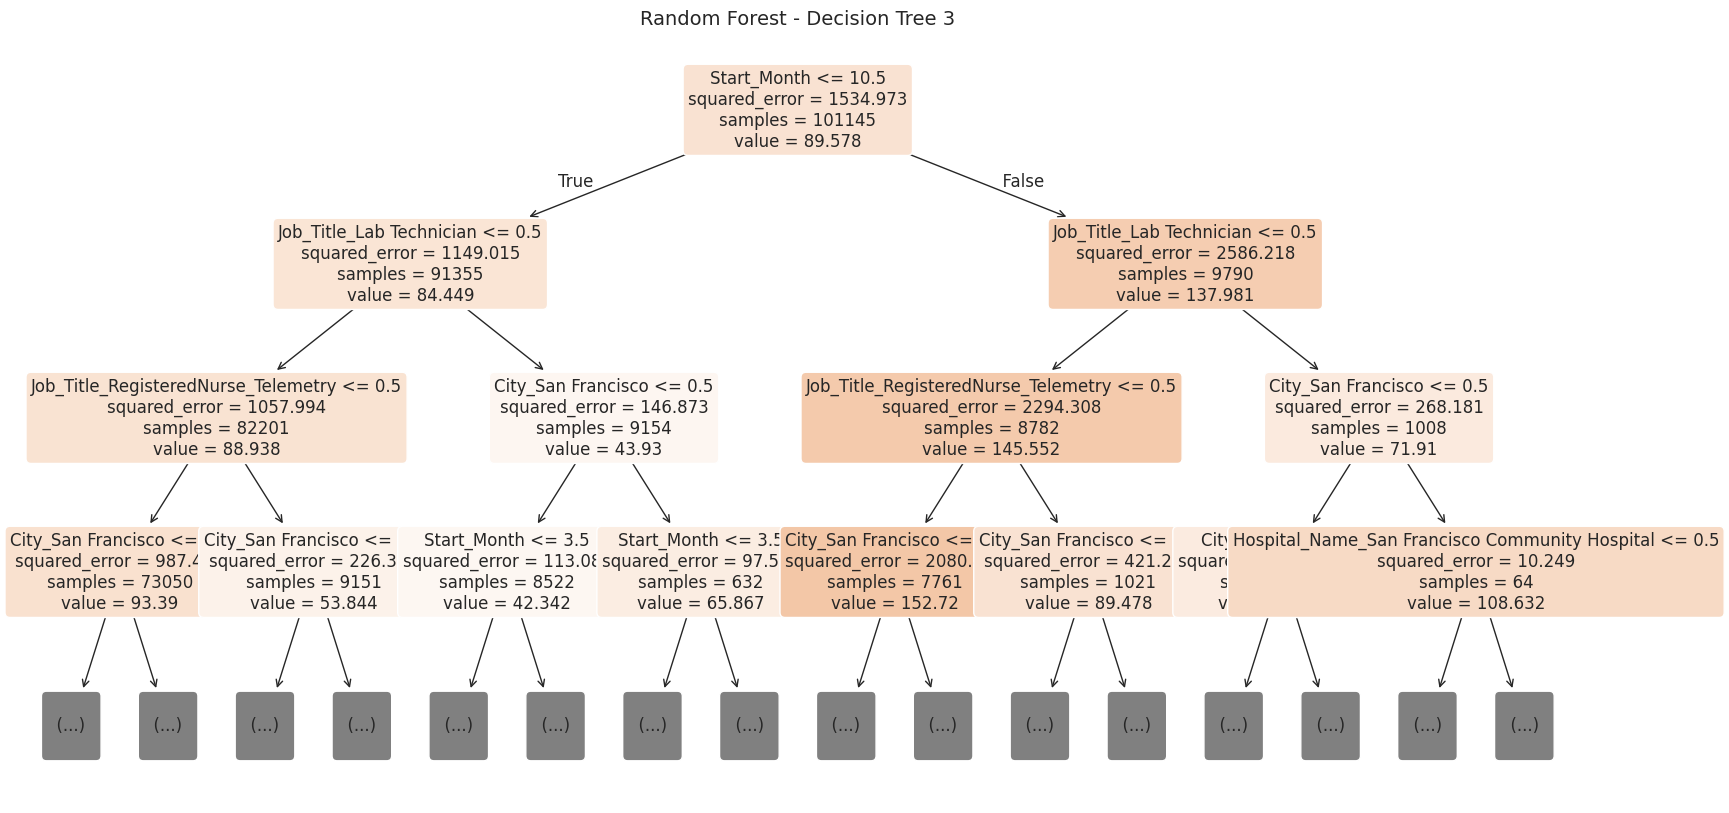

In [ ]:
# Prepare residuals
residuals = y_test - rf_preds

# Scatter plot: Actual vs Predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=rf_preds, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')
plt.title('Actual vs Predicted (Random Forest)', fontsize=14)
plt.xlabel('Actual Hourly Pay Rate', fontsize=12)
plt.ylabel('Predicted Hourly Pay Rate', fontsize=12)
plt.grid()
plt.show()


# Get the first three trees from the best Random Forest model
trees = best_rf_model.named_steps['regressor'].estimators_

# This ensures that the feature names match the feature importances of the trained model.
onehot_features = best_rf_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_features = np.concatenate([onehot_features, numerical_features])

# Plot the first three trees
for i in range(min(3, len(trees))):  # Plot up to 3 trees (or fewer if there are less than 3 trees)
    plt.figure(figsize=(20, 10))
    plot_tree(trees[i], filled=True, feature_names=all_features,
              rounded=True, fontsize=12, max_depth=3)  # Limit depth for clearer visualization
    plt.title(f"Random Forest - Decision Tree {i+1}", fontsize=14)
    plt.show()




# Implement ML LightGBM (Light Gradient Boosting Machine) models to predict the hourly rate

# Useful links to study and understand LightGBM

1) https://www.kdnuggets.com/2020/06/lightgbm-gradient-boosting-decision-tree.html

2) https://cienciadedatos.net/documentos/py58-forecasting-time-series-with-lightgbm.html

3) https://hands-on.cloud/lightgbm-algorithm-supervised-machine-learning-in-python/

4)https://www.geeksforgeeks.org/regression-using-lightgbm/

LightGBM is a gradient boosting framework that builds **decision trees leaf-wise, optimizing for the best split at each leaf**. This approach often results in higher accuracy and faster training times compared to level-wise tree growth

**Advantages in Predicting Hourly Pay Rates :** Faster training speed and higher efficiency , Lower memory usage , Better accuracy , Support of parallel and GPU learning , Capable of handling large-scale data

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 114
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Info] Start training from score 89.471993
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	train's l2: 8.45914	valid's l2: 8.57746
[LightGBM] [Warning]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



LightGBM Performance:
MSE: 8.33
R²: 0.99


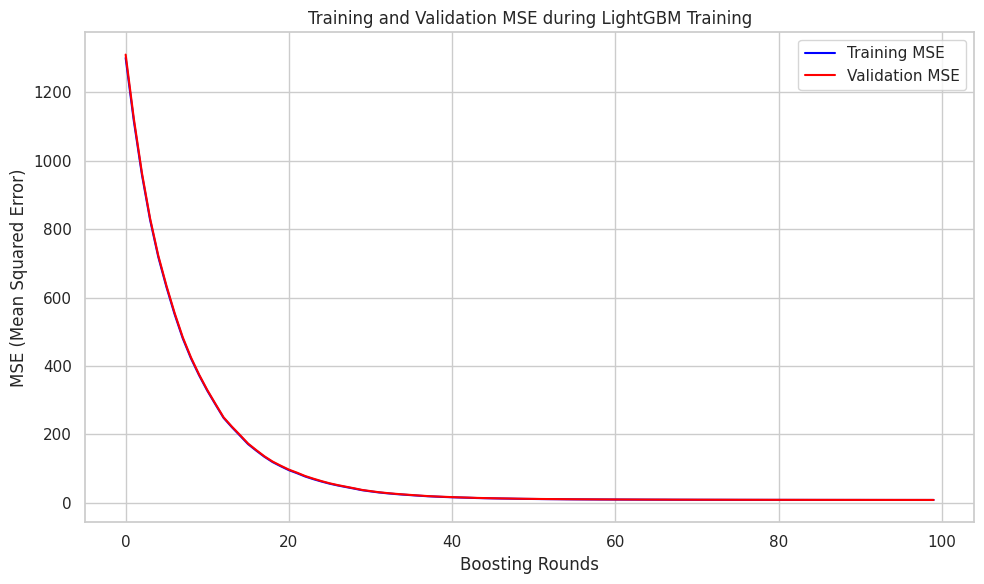

<Axes: >

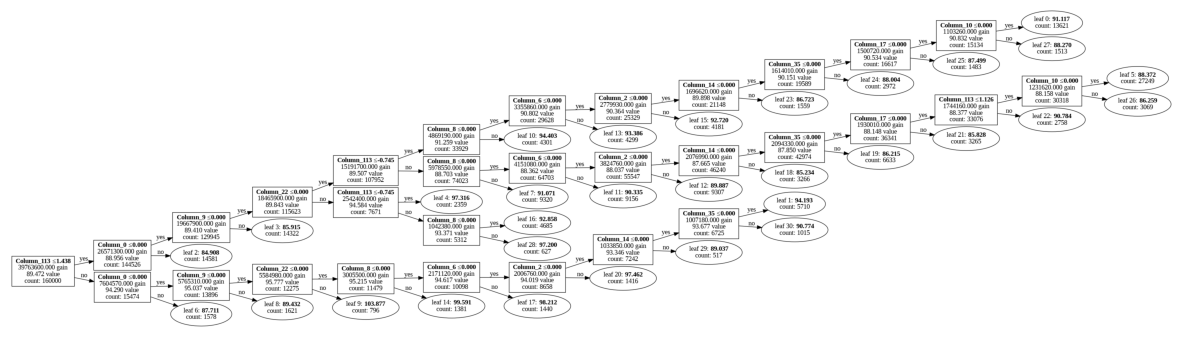

In [ ]:
# Preprocessing pipeline for categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Job_Title', 'City', 'State', 'Hospital_Name']),
        ('num', StandardScaler(), ['Contract_Duration', 'Start_Month'])
    ]
)

# Apply preprocessing to X_train and X_val separately for LightGBM
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)

# LightGBM model with early stopping handled outside the pipeline
lgb_model = LGBMRegressor(
    objective='regression',
    n_estimators=100,
    early_stopping_rounds=5,
    eval_metric='mse',  # Use 'mse' to track Mean Squared Error
    random_state=42
)

# Train LightGBM model with early stopping
lgb_model.fit(
    X_train_transformed,
    y_train,
    eval_set=[(X_train_transformed, y_train), (X_val_transformed, y_val)],
    eval_names=['train', 'valid']
)

# Predict and evaluate LightGBM
lgb_preds = lgb_model.predict(preprocessor.transform(X_test))
print("\nLightGBM Performance:")
print(f"MSE: {mean_squared_error(y_test, lgb_preds):.2f}")
print(f"R²: {r2_score(y_test, lgb_preds):.2f}")

# Access the evaluation history
evals_result = lgb_model.evals_result_

# Plot the gradient curve showing training and validation errors using MSE
plt.figure(figsize=(10, 6))

# The keys are now 'train' and 'valid' (or the names you specified in eval_names)
plt.plot(evals_result['train']['l2'], label='Training MSE', color='blue')
plt.plot(evals_result['valid']['l2'], label='Validation MSE', color='red')

plt.title('Training and Validation MSE during LightGBM Training')
plt.xlabel('Boosting Rounds')
plt.ylabel('MSE (Mean Squared Error)')
plt.legend()
plt.tight_layout()
plt.show()

# Plot the tree structure for the first tree up to depth 3
# depth 3 will display a tree with the first three levels of decision-making
lightgb.plot_tree(lgb_model, tree_index=0, figsize=(15, 10), show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])



# Implement DL Neural network models to predict the hourly rate

# Useful links to study and understand LightGBM

1) https://scholarworks.lib.csusb.edu/cgi/viewcontent.cgi?article=1040&context=jiim

2)https://www.researchgate.net/publication/234061691_Prediction_Of_Hourly_And_Daily_Diffuse_Fraction_Using_Neural_Network_As_Compared_To_Linear_Regression_Models

3) https://alexanderquispe.github.io/ml_book/deep-neural-networks-for-wage-prediction.html

4) https://link.springer.com/article/10.1007/s11081-024-09883-7

Neural Networks are computational models **inspired by the human brain**, consisting of interconnected nodes (neurons) organized in layers

The neural network **learns the weights and biases** during training to minimize the loss function, such as mean squared error.

**Modeling Complex Patterns:** Neural Networks can capture intricate, non-linear relationships between features and the target variable.

**Flexibility:** They can model interactions between features without explicit specification

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 1487.1757 - mean_absolute_error: 24.4625 - val_loss: 67.7208 - val_mean_absolute_error: 5.7277
Epoch 2/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 246.5938 - mean_absolute_error: 11.3877 - val_loss: 58.1914 - val_mean_absolute_error: 5.1729
Epoch 3/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 223.2590 - mean_absolute_error: 10.7068 - val_loss: 47.4628 - val_mean_absolute_error: 4.6954
Epoch 4/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 201.8905 - mean_absolute_error: 10.1397 - val_loss: 40.2273 - val_mean_absolute_error: 4.4365
Epoch 5/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 189.9025 - mean_absolute_error: 9.7892 - val_loss: 37.5718 - val_mean_absolute_error: 4.2141
Epoch 6/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 179.1418 - mean_absolute_error: 9.5147 - val_loss: 43.1096 - val_mean_absolute_error: 4.4372
Epoch 7/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - lo

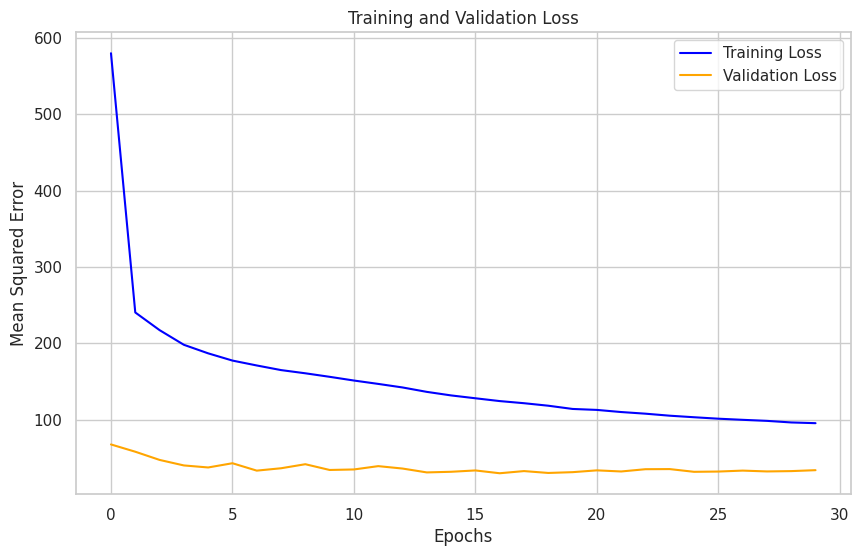

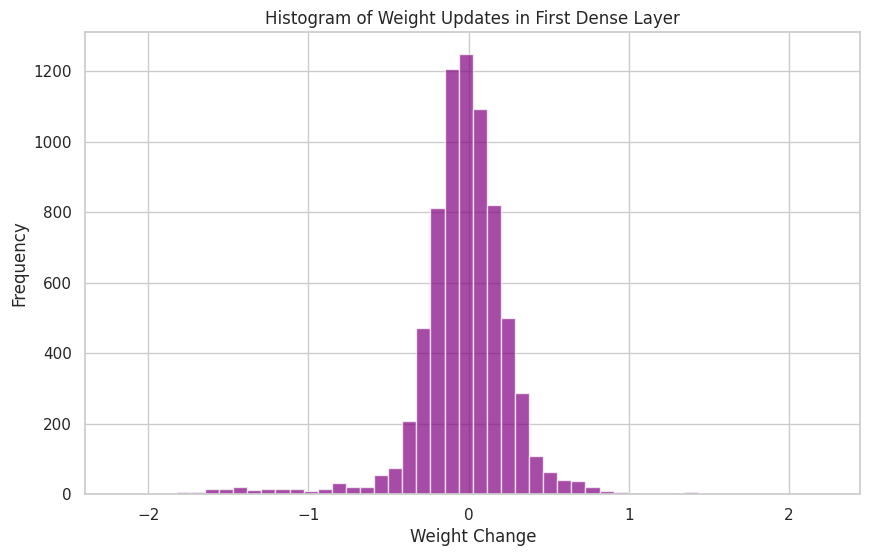

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


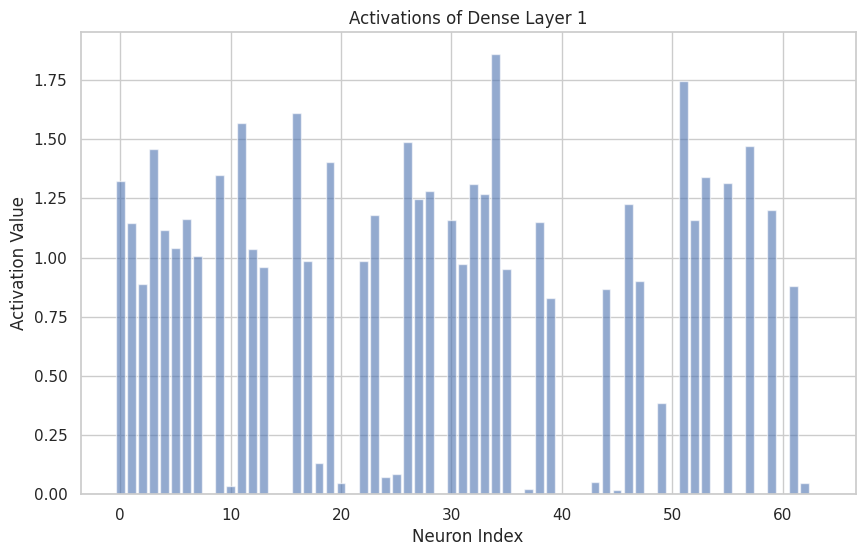

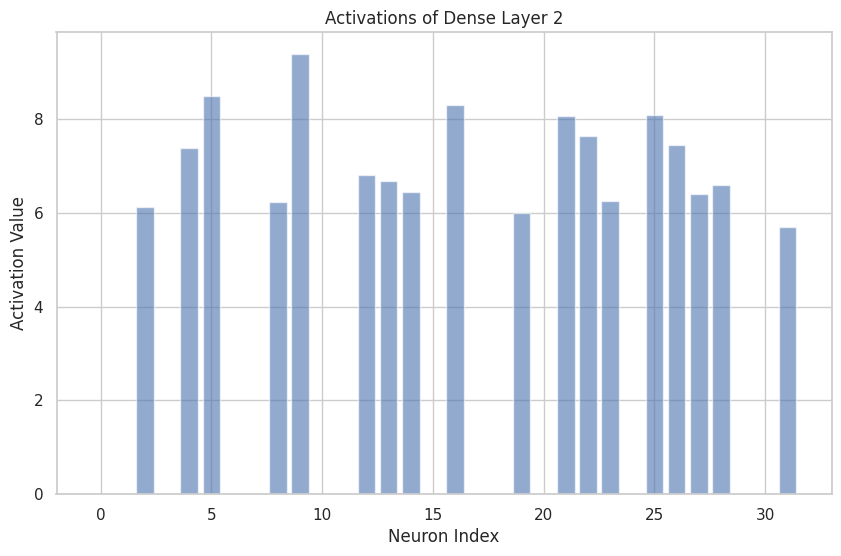

In [ ]:
# Define the neural network model
def create_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_transformed.shape[1],), name='dense_1'),
        Dropout(0.2),
        Dense(32, activation='relu', name='dense_2'),
        Dropout(0.2),
        Dense(1, activation='linear', name='output')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

# Create and compile the KerasRegressor model
nn_model = create_model()

# Capture initial weights before training
initial_weights = nn_model.get_weights()

# Train the neural network model
history = nn_model.fit(
    X_train_transformed,
    y_train,
    validation_data=(X_val_transformed, y_val),
    epochs=30,
    batch_size=32,
    verbose=1
)

# Apply the same preprocessing to X_test
X_test_transformed = preprocessor.transform(X_test)

# Predict and evaluate the neural network model
nn_preds = nn_model.predict(X_test_transformed)

print("\nNeural Network Performance:")
print(f"MAE: {mean_absolute_error(y_test, nn_preds):.2f}")
print(f"MSE: {mean_squared_error(y_test, nn_preds):.2f}")
print(f"R²: {r2_score(y_test, nn_preds):.2f}")

# Capture final weights after training
final_weights = nn_model.get_weights()

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Compare weight changes for the first dense layer
weights_initial = np.array(initial_weights[0])  # First layer weights
weights_final = np.array(final_weights[0])  # First layer weights after training
weight_diff = weights_final - weights_initial

# Visualize weight changes
plt.figure(figsize=(10, 6))
plt.hist(weight_diff.flatten(), bins=50, alpha=0.7, color='purple')
plt.xlabel('Weight Change')
plt.ylabel('Frequency')
plt.title('Histogram of Weight Updates in First Dense Layer')
plt.grid(True)
plt.show()

# Visualize activations for one test input
# Get the input layer of your model
input_layer = nn_model.layers[0].input

# Define layer outputs for activations
layer_outputs = [layer.output for layer in nn_model.layers if 'dense' in layer.name]

# Create the activation model
activation_model = tf.keras.models.Model(inputs=input_layer, outputs=layer_outputs) # Use input_layer here

# Select one input sample for visualization
sample_input = X_test_transformed[0].reshape(1, -1)
activations = activation_model.predict(sample_input)

# Plot activations for each dense layer
for i, activation in enumerate(activations, start=1):
    plt.figure(figsize=(10, 6))
    plt.bar(range(activation.shape[1]), activation.flatten(), alpha=0.6)
    plt.xlabel('Neuron Index')
    plt.ylabel('Activation Value')
    plt.title(f'Activations of Dense Layer {i}')
    plt.grid(True)
    plt.show()


# Implement a Streamlit application to demo the model. The Streamlit app should allow the user to input a requirement (Job Title, Location, Hospital, Contract Start Date & Contract End Date) and show the predicted Hourly Rate

In [ ]:
import joblib

# Assuming best_rf_model is your trained Random Forest model
joblib.dump(best_rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [ ]:
!pip install streamlit

# app.py code

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from datetime import date
import joblib

# Load the trained Random Forest model
rf_model = joblib.load('/content/random_forest_model.pkl')

# Define preprocessing pipeline for categorical and numerical features
categorical_features = ['Job_Title', 'City', 'State', 'Hospital_Name']
numerical_features = ['Contract_Duration', 'Start_Month']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)

# Streamlit app
st.title("Hourly Pay Rate Prediction")

# User inputs
job_title = st.text_input("Job Title")
city = st.text_input("City")
state = st.text_input("State")
hospital_name = st.text_input("Hospital Name")
start_date = st.date_input("Contract Start Date", value=date.today())
end_date = st.date_input("Contract End Date", value=date.today())

if st.button("Predict"):
    # Validate date input
    if end_date <= start_date:
        st.error("Contract End Date must be after Contract Start Date.")
    else:
        # Calculate contract duration
        contract_duration = (end_date - start_date).days

        # Extract month from contract start date
        start_month = start_date.month

        # Create a DataFrame with the input data
        input_data = pd.DataFrame({
            'Job_Title': [job_title],
            'City': [city],
            'State': [state],
            'Hospital_Name': [hospital_name],
            'Contract_Duration': [contract_duration],
            'Start_Month': [start_month]
        })

        # Apply preprocessing
        input_data_transformed = preprocessor.transform(input_data)

        # Predict the hourly pay rate
        predicted_hourly_rate = rf_model.predict(input_data_transformed)

        # Display the predicted hourly rate
        st.subheader("Prediction Results")
        st.write(f"**Job Title:** {job_title}")
        st.write(f"**City:** {city}")
        st.write(f"**State:** {state}")
        st.write(f"**Hospital Name:** {hospital_name}")
        st.write(f"**Contract Start Date:** {start_date}")
        st.write(f"**Contract End Date:** {end_date}")
        st.success(f"**Predicted Hourly Pay Rate:** ${predicted_hourly_rate[0]:.2f}")


In [ ]:
!pip install streamlit -q

In [ ]:
! wget -q -O - ipv4.txt ipv4.icanhazip.com

34.150.212.129


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501




⠙
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.150.212.129:8501

⠹⠸⠼⠴⠦⠧⠇your url is: https://purple-keys-matter.loca.lt
